In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations
import pandas as pd
from pathlib import Path
import numpy as np
from dataclasses import dataclass
import plotly.express as px
import json
pd.set_option('display.max_rows', 500)

import os
import glob
import pickle
from rdkit.Chem import Draw
from rdkit import Chem

# Get results on inference
here we use downloads from
- gs://plinder-collab-bucket/xuejin_meta_data/ml_workshop_data/testset
- gs://plinder-collab-bucket/2024-04/v1/leakage

In [2]:
# output_diffdock_dir = Path('gs://plinder-collab-bucket/xuejin_meta_data/ml_workshop_data/testset')
output_diffdock_dir = Path('/Users/vladas/plinder_local_data/testset')
if not output_diffdock_dir.exists():
    os.system(f'gsutil -m cp -r gs://plinder-collab-bucket/xuejin_meta_data/ml_workshop_data/testset {output_diffdock_dir}')
output_maxsim_dir = 'gs://plinder-collab-bucket/2024-04/v1/leakage'
# output_maxsim_dir = Path('/Users/vladas/plinder_local_data/leakage')

In [3]:
metrics_dict = {
    'pocket_qcov': 'POCKET SHARED', 
    'pocket_lddt': 'POCKET LDDT',
    'protein_lddt_qcov_weighted_sum': 'PROTEIN LDDT',
    'protein_seqsim_weighted_sum': 'PROTEIN SEQSIM',
    'pli_qcov': 'PLI SHARED',
    'tanimoto_similarity_max': 'LIGAND SIMILARITY',
}
metrics_dict.keys()

dict_keys(['pocket_qcov', 'pocket_lddt', 'protein_lddt_qcov_weighted_sum', 'protein_seqsim_weighted_sum', 'pli_qcov', 'tanimoto_similarity_max'])

In [4]:
model_mapping = {
    'ecod': 'plinder_v0',
    'hard': 'plinder_time',
    'time': 'plinder_ecod'
}

dfs = []
for file in list(glob.glob(f"{output_diffdock_dir}/*.csv")):
    # print(file)
    df = pd.read_csv(file)
    name = file.split('/')[-1]
    testset = name.split('_')[0]
    model = name.split('_')[1]
    seed = name.split('_')[-1].split('.')[0]
    df['inference_set'] = testset
    df['model'] = model_mapping[model]
    df['seed'] = seed
    if testset == 'posebuster':
        df['id'] = df['id'].apply(lambda x: x.lower().split('_')[0])
    dfs.append(df)
dfs = pd.concat(dfs)
dfs = dfs.rename(columns={'id':'system_id'})
dfs

,system_id,rank,score,rmsd,dr,inference_set,model,seed
0,16pk__1__1.A__1.B,5,-2.23,3.148070,1.040803,valid,plinder_v0,55
1,16pk__1__1.A__1.B,9,-3.30,4.055051,2.588200,valid,plinder_v0,55
2,16pk__1__1.A__1.B,1,-1.37,5.564755,4.457572,valid,plinder_v0,55
3,16pk__1__1.A__1.B,2,-1.49,6.464864,5.554993,valid,plinder_v0,55
4,16pk__1__1.A__1.B,10,-4.96,12.848423,7.811364,valid,plinder_v0,55
...,...,...,...,...,...,...,...,...
4265,8slg,2,-1.74,8.061517,3.648560,posebuster,plinder_time,51
4266,8slg,9,-4.01,3.787216,0.375957,posebuster,plinder_time,51
4267,8slg,7,-3.10,6.629079,2.032816,posebuster,plinder_time,51
4268,8slg,6,-2.48,8.748929,4.268572,posebuster,plinder_time,51


In [5]:
df_bestpose = dfs.pivot_table(index=['model', 'inference_set', 'system_id',], values='rmsd', aggfunc=np.min)
df_bestpose = df_bestpose.reset_index()

df_bestpose['success'] = df_bestpose['rmsd'] <= 2
df_bestpose = df_bestpose[df_bestpose['inference_set'] == 'posebuster']

# Create a new column 'metric' in best_performance that contains the list of metrics
df_bestpose['metric'] = [list(metrics_dict)] * len(df_bestpose)

# Explode the 'metric' column to replicate each row for each metric
df_bestpose = df_bestpose.explode('metric')
df_bestpose

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_46908/3194890210.py:1: FutureWarning: The provided callable <function min at 0x1057bf700> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_bestpose = dfs.pivot_table(index=['model', 'inference_set', 'system_id',], values='rmsd', aggfunc=np.min)


,model,inference_set,system_id,rmsd,success,metric
0,plinder_ecod,posebuster,5s8i,2.363514,False,pocket_qcov
0,plinder_ecod,posebuster,5s8i,2.363514,False,pocket_lddt
0,plinder_ecod,posebuster,5s8i,2.363514,False,protein_lddt_qcov_weighted_sum
0,plinder_ecod,posebuster,5s8i,2.363514,False,protein_seqsim_weighted_sum
0,plinder_ecod,posebuster,5s8i,2.363514,False,pli_qcov
...,...,...,...,...,...,...
15698,plinder_v0,posebuster,8slg,0.544956,True,pocket_lddt
15698,plinder_v0,posebuster,8slg,0.544956,True,protein_lddt_qcov_weighted_sum
15698,plinder_v0,posebuster,8slg,0.544956,True,protein_seqsim_weighted_sum
15698,plinder_v0,posebuster,8slg,0.544956,True,pli_qcov


In [6]:
dfs_maxsim = []
for metric in metrics_dict.keys():
    for model in ['plinder-v0', 'plinder-Time', 'plinder-ECOD']:
        filename = f'{model}__{metric}__train_posebusters.parquet'
        df_maxsim = pd.read_parquet(f'{output_maxsim_dir}/{filename}')
        df_maxsim['metric'] =  metric
        df_maxsim['model'] =  model.replace("-", "_").lower()
        df_maxsim['inference_set'] = "posebuster"
        # df_maxsim["similarity"] /= 100
        df_maxsim.rename(columns={"query_system": "system_id"}, inplace=True)
        df_maxsim['system_id'] = df_maxsim['system_id'].apply(lambda x: x.lower().split('_')[0])
        print(filename, df_maxsim.shape[0])
        dfs_maxsim.append(df_maxsim)
dfs_maxsim = pd.concat(dfs_maxsim)
print(len(dfs_maxsim))
dfs_maxsim = dfs_maxsim.sort_values('similarity', ascending=False).groupby(['system_id', 'model', 'inference_set', 'metric']).agg('first').reset_index()
print(len(dfs_maxsim))
dfs_maxsim.head()

plinder-v0__pocket_qcov__train_posebusters.parquet 406
plinder-Time__pocket_qcov__train_posebusters.parquet 640
plinder-ECOD__pocket_qcov__train_posebusters.parquet 527
plinder-v0__pocket_lddt__train_posebusters.parquet 365
plinder-Time__pocket_lddt__train_posebusters.parquet 659
plinder-ECOD__pocket_lddt__train_posebusters.parquet 554
plinder-v0__protein_lddt_qcov_weighted_sum__train_posebusters.parquet 368
plinder-Time__protein_lddt_qcov_weighted_sum__train_posebusters.parquet 661
plinder-ECOD__protein_lddt_qcov_weighted_sum__train_posebusters.parquet 561
plinder-v0__protein_seqsim_weighted_sum__train_posebusters.parquet 484
plinder-Time__protein_seqsim_weighted_sum__train_posebusters.parquet 685
plinder-ECOD__protein_seqsim_weighted_sum__train_posebusters.parquet 597
plinder-v0__pli_qcov__train_posebusters.parquet 345
plinder-Time__pli_qcov__train_posebusters.parquet 615
plinder-ECOD__pli_qcov__train_posebusters.parquet 511
plinder-v0__tanimoto_similarity_max__train_posebusters.parq

,system_id,model,inference_set,metric,similarity
0,10mh,plinder_ecod,posebuster,tanimoto_similarity_max,83
1,10mh,plinder_time,posebuster,tanimoto_similarity_max,83
2,10mh,plinder_v0,posebuster,tanimoto_similarity_max,83
3,11as,plinder_ecod,posebuster,tanimoto_similarity_max,100
4,11as,plinder_time,posebuster,tanimoto_similarity_max,100


In [7]:
dfs_bestrmsd_maxsim = pd.merge(df_bestpose, dfs_maxsim, on=['system_id', 'model', 'inference_set', 'metric'], how='left')
dfs_bestrmsd_maxsim['similarity'] = dfs_bestrmsd_maxsim['similarity'].fillna(0)
dfs_bestrmsd_maxsim

,model,inference_set,system_id,rmsd,success,metric,similarity
0,plinder_ecod,posebuster,5s8i,2.363514,False,pocket_qcov,100.0
1,plinder_ecod,posebuster,5s8i,2.363514,False,pocket_lddt,100.0
2,plinder_ecod,posebuster,5s8i,2.363514,False,protein_lddt_qcov_weighted_sum,100.0
3,plinder_ecod,posebuster,5s8i,2.363514,False,protein_seqsim_weighted_sum,100.0
4,plinder_ecod,posebuster,5s8i,2.363514,False,pli_qcov,100.0
...,...,...,...,...,...,...,...
7681,plinder_v0,posebuster,8slg,0.544956,True,pocket_lddt,0.0
7682,plinder_v0,posebuster,8slg,0.544956,True,protein_lddt_qcov_weighted_sum,0.0
7683,plinder_v0,posebuster,8slg,0.544956,True,protein_seqsim_weighted_sum,100.0
7684,plinder_v0,posebuster,8slg,0.544956,True,pli_qcov,0.0


<Axes: >

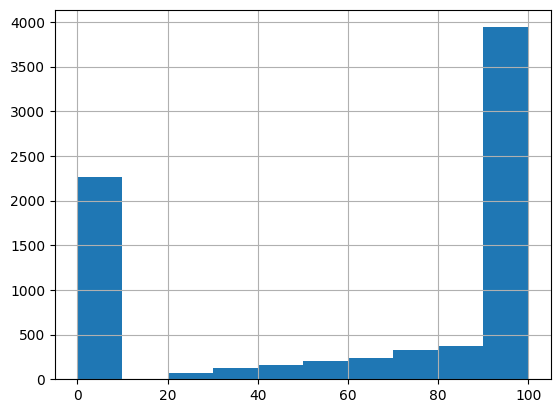

In [8]:
dfs_bestrmsd_maxsim['similarity'].hist()

In [9]:
len(dfs_bestrmsd_maxsim.drop_duplicates(['model', 'inference_set','system_id', 'metric']))

7686

In [10]:
def perf_vs_traindist(
    dfs,
    metric='pli_qcov',
    bins=np.linspace(0, 100, 11),
    groupby='model',
    ):
    dfs = dfs[dfs['metric'] == metric].copy()
    # Y0: excess success rate
    # Y1: enrichment factor
    # Y2: delta average RMSD
    # Y3: CDF for leaked systems
    Y = []
    for model, dfi in dfs.groupby(groupby):
        sr_total = sum(dfi['success']) / len(dfi)
        mean_rmsd_total = sum(dfi['rmsd']) / len(dfi)
        y = {
            'XS': [],
            'EF' : [],
            'delRMSD': [],
            'CDF': []
        }
        for dist in bins:
            train_leaked = dfi['similarity'] >= 100 - dist
            sr = sum(dfi[train_leaked]['success']) / np.max([sum(train_leaked), 1])
            mean_rmsd = sum(dfi['rmsd'][train_leaked]) / np.max([sum(train_leaked), 1])
            fraction_leaked = sum(train_leaked) / len(train_leaked)
            y['XS'].append(sr - sr_total)
            y['EF'].append(sr / sr_total)
            y['delRMSD'].append(mean_rmsd - mean_rmsd_total)
            y['CDF'].append(fraction_leaked)
        Y.append(y)
    trends = {k: np.array([yi[k] for yi in Y]) for k in Y[0].keys()}
    # trends['distance_to_train'] = bins
    return trends


def perf_vs_traindist_all(dfall, xbins=np.linspace(0, 100, 11)):
    data = []
    for met, dfs in dfall.groupby('metric'):
        trends = perf_vs_traindist(dfs, metric=met, bins=xbins)
        for k, v in trends.items():
            data += [{
                'metric': met,
                'cutoff': x,
                "mean": np.mean(v[:,ix]),
                "err": np.std(v[:,ix]) / np.sqrt(len(v[:,ix])),
                "analysis": k,
            } 
            for ix, x in enumerate(xbins)]
    return pd.DataFrame.from_records(data)

In [11]:
df_report = perf_vs_traindist_all(dfs_bestrmsd_maxsim)

# Plot

In [12]:
def plot_leakage_vs_perfomance(
        df_analysis,
        # analysis_Y='CDF',
        analysis_Y = 'EF',
        # analysis_Y = 'XS',
        # analysis_Y = 'delRMSD,
        exclude_ligand=False,
        plot_dimension=(400, 650)
    ):

    analysis_to_yaxis_label = {
        'XS': "Excess Success Rate",
        'EF': "Enrichment Factor",
        'delRMSD': "Change in mean RMSD",
        'CDF': "Cumulative Leakage Fraction"
    }
    xaxis_label = 'Similarity Distance to Train Set'

    symbols = ['circle', 'square', 'star', 'diamond', 'hourglass', 'pentagon', 'cross']
    colors = ["lightblue", "pink", "lightgreen", "purple", "goldenrod", 'red', 'blue']

    df_plot = df_analysis[df_analysis.analysis==analysis_Y]
    df_plot.metric = df_plot.metric.map(metrics_dict)
    df_plot = df_plot.rename(columns={"cutoff": xaxis_label, "mean" : analysis_to_yaxis_label[analysis_Y], 'metric': 'Metric'})
    if exclude_ligand:
        df_plot =  df_plot[~df_plot.Metric.apply(lambda x : "LIGAND" in x)]
    
    no_of_colors =  len(df_plot.Metric.unique())

    fig = px.scatter(
            df_plot,
            x=xaxis_label,
            y=analysis_to_yaxis_label[analysis_Y],
            color="Metric",
            error_y='err',
            # trendline="lowess",
            color_discrete_sequence=colors[:no_of_colors],
            symbol="Metric",
            symbol_sequence=symbols[:no_of_colors],
                        height=plot_dimension[0],
                        width=plot_dimension[1]
    )

    fig.update_layout(
        {"plot_bgcolor": "rgba(0, 0, 0, 0)"},
        legend=dict(
            # x=0,
            # y=1,
            traceorder="normal",
            font=dict(
                size=16,
                color="black"
            ),
        ),
        font=dict(
            size=18,  # Set the font size here
        ),
        # yaxis_title="Success Rate",
        # xaxis_title="Fraction of leaked systems",
        yaxis = dict(
        tickfont = dict(size=18)),
        xaxis = dict(
        tickfont = dict(size=18)),
        legend_title=None
    )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', color='black')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', color='black')
    fig.update_traces(marker=dict(size=12,
                                line=dict(width=1,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
    config = {
        'toImageButtonOptions': {
            'format': 'png', # one of png, svg, jpeg, webp
            'filename': f'simtotrain_vs_{analysis_Y}',
            # 'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    return fig.show(config=config)


In [13]:
plot_leakage_vs_perfomance(df_report, analysis_Y='EF')

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_46908/3198298359.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.metric = df_plot.metric.map(metrics_dict)


In [14]:
plot_leakage_vs_perfomance(df_report, analysis_Y='CDF')

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_46908/3198298359.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
plot_leakage_vs_perfomance(df_report, analysis_Y='XS')

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_46908/3198298359.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
plot_leakage_vs_perfomance(df_report, analysis_Y='delRMSD')

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_46908/3198298359.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

